# ClimateHack.AI 2023: Training a Basic Model

Thank you for participating in ClimateHack.AI 2023! 

Your contributions could help cut carbon emissions by up to 100 kilotonnes per year in Great Britain alone. We look forward to seeing what you build over the course of the competition!

In this Jupyter notebook, you will hopefully train your first model for the challenge using historical solar PV data and HRV satellite imagery.

## Installing packages

Before you can get started, you will need to install a number of packages to allow you to work with the data and submit to the platform. If you do not already have these packages installed, you can uncomment the lines below to do so! You will also need to [install PyTorch](https://pytorch.org/get-started/locally/).

In [1]:
# %pip install numpy matplotlib zarr xarray ipykernel gcsfs fsspec dask cartopy ocf-blosc2 torchinfo
# %pip install -U doxa-cli

## Importing packages

Here, we import a number of packages we will need to train our first model.

In [4]:
import os
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from ocf_blosc2 import Blosc2
from torch.utils.data import DataLoader, IterableDataset
from torchinfo import summary
import json

plt.rcParams["figure.figsize"] = (20, 12)

In [39]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=1)

## Downloading a month of data

While streaming the Zarr-format datasets directly from Hugging Face was adequate for some initial data exploration in `1_data.ipynb`, it most likely will not be fast enough in training. Since there is so much data available, we can get started just by downloading a single month of PV and HRV satellite imagery data.

In [8]:
if not os.path.exists("data"):
    os.makedirs("data/pv/2020", exist_ok=True)
    os.makedirs("data/satellite-hrv/2020", exist_ok=True)

    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/metadata.csv --output data/pv/metadata.csv
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/pv/2020/7.parquet --output data/pv/2020/7.parquet
    !curl -L https://huggingface.co/datasets/climatehackai/climatehackai-2023/resolve/main/satellite-hrv/2020/7.zarr.zip --output data/satellite-hrv/2020/7.zarr.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1300k  100 1300k    0     0  3551k      0 --:--:-- --:--:-- --:--:-- 3552k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1122  100  1122    0     0  10890      0 --:--:-- --:--:-- --:--:-- 11000
100 74.3M  100 74.3M    0     0  40.3M      0  0:00:01  0:00:01 --:--:-- 61.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1188  100  1188    0     0   8821      0 --:--:-- --:--:-- --:--:--  8865
100 4049M  100 4049M    0     0  80.0M      0  0:00:50  0:00:50 --:--:-- 77.1M.9M      0  0:00:50  0:00:22  0:00:28 80.6M


## Loading the data

In [10]:
pv = pd.read_parquet("data/pv/2020/7.parquet").drop("generation_wh", axis=1)

pv

power
timestamp                 ss_id       
2020-07-01 00:00:00+00:00 2607     0.0
                          2626     0.0
                          2631     0.0
                          2657     0.0
                          2729     0.0
...                                ...
2020-07-31 23:55:00+00:00 27062    0.0
                          27063    0.0
                          27064    0.0
                          27065    0.0
                          27066    0.0

[7827134 rows x 1 columns]

In [11]:
hrv = xr.open_dataset(
    "data/satellite-hrv/2020/7.zarr.zip", engine="zarr", chunks="auto"
)

hrv

<xarray.Dataset>
Dimensions:                      (channel: 1, time: 6721, y_geostationary: 592,
                                  x_geostationary: 684)
Coordinates:
  * channel                      (channel) <U3 'HRV'
  * time                         (time) datetime64[ns] 2020-07-01T04:00:00 .....
  * x_geostationary              (x_geostationary) float64 -1.089e+06 ... -4....
  * y_geostationary              (y_geostationary) float64 4.449e+06 ... 5.04...
Data variables:
    data                         (time, y_geostationary, x_geostationary, channel) float16 dask.array<chunksize=(165, 592, 684, 1), meta=np.ndarray>
    x_geostationary_coordinates  (time, x_geostationary) float64 dask.array<chunksize=(6721, 684), meta=np.ndarray>
    y_geostationary_coordinates  (time, y_geostationary) float64 dask.array<chunksize=(6721, 592), meta=np.ndarray>

As part of the challenge, you can make use of satellite imagery, numerical weather prediction and air quality forecast data in a `[128, 128]` region centred on each solar PV site. In order to help you out, we have pre-computed the indices corresponding to each solar PV site and included them in `indices.json`, which we can load directly. For more information, take a look at the [challenge page](https://doxaai.com/competition/climatehackai-2023).


In [12]:
with open("indices.json") as f:
    site_locations = {
        data_source: {
            int(site): (int(location[0]), int(location[1]))
            for site, location in locations.items()
        }
        for data_source, locations in json.load(f).items()
    }

### Defining a PyTorch Dataset

To get started, we will define a simple `IterableDataset` that shows how to slice into the PV and HRV data using `pandas` and `xarray`, respectively. You will have to modify this if you wish to incorporate non-HRV data, weather forecasts and air quality forecasts into your training regimen. If you have any questions, feel free to ask on the [ClimateHack.AI Community Discord server](https://discord.gg/HTTQ8AFjJp)!

**Note**: `site_locations` contains indices for the non-HRV, weather forecast and air quality forecast data as well as for the HRV data!

There are many more advanced strategies you could implement to load data in training, particularly if you want to pre-prepare training batches in advance or use multiple workers to improve data loading times.

In [13]:
class ChallengeDataset(IterableDataset):
    def __init__(self, pv, hrv, site_locations, sites=None):
        self.pv = pv
        self.hrv = hrv
        self._site_locations = site_locations
        self._sites = sites if sites else list(site_locations["hrv"].keys())

    def _get_image_times(self):
        min_date = datetime(2020, 7, 1)
        max_date = datetime(2020, 7, 30)

        start_time = time(8)
        end_time = time(17)

        date = min_date
        while date <= max_date:
            current_time = datetime.combine(date, start_time)
            while current_time.time() < end_time:
                if current_time:
                    yield current_time

                current_time += timedelta(minutes=60)

            date += timedelta(days=1)

    def __iter__(self):
        for time in self._get_image_times():
            first_hour = slice(str(time), str(time + timedelta(minutes=55)))

            pv_features = pv.xs(first_hour, drop_level=False)  # type: ignore
            pv_targets = pv.xs(
                slice(  # type: ignore
                    str(time + timedelta(hours=1)),
                    str(time + timedelta(hours=4, minutes=55)),
                ),
                drop_level=False,
            )

            hrv_data = self.hrv["data"].sel(time=first_hour).to_numpy()

            for site in self._sites:
                try:
                    # Get solar PV features and targets
                    site_features = pv_features.xs(site, level=1).to_numpy().squeeze(-1)
                    site_targets = pv_targets.xs(site, level=1).to_numpy().squeeze(-1)
                    assert site_features.shape == (12,) and site_targets.shape == (48,)

                    # Get a 128x128 HRV crop centred on the site over the previous hour
                    x, y = self._site_locations["hrv"][site]
                    hrv_features = hrv_data[:, y - 64 : y + 64, x - 64 : x + 64, 0]
                    assert hrv_features.shape == (12, 128, 128)

                    # How might you adapt this for the non-HRV, weather and aerosol data?
                except:
                    continue

                yield site_features, hrv_features, site_targets

## Defining a model

In order to make a PyTorch-based submission to the DOXA AI platform, you need to upload both the code defining your model in addition to your trained model weights (and some code to run your model). As a result, if you want to experiment with different model architectures using this notebook, you will need to edit the model in `submission/model.py` and re-import it here.

Here is the small convolutional neural network you are initially given in `submission/model.py`. You will absolutely be able to improve upon this!

```py
#########################################
#       Improve this basic model!       #
#########################################

class Model(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(6924, 48)

    def forward(self, pv, hrv):
        x = torch.relu(self.pool(self.conv1(hrv)))
        x = torch.relu(self.pool(self.conv2(x)))
        x = torch.relu(self.pool(self.conv3(x)))
        x = torch.relu(self.pool(self.conv4(x)))

        x = self.flatten(x)
        x = torch.concat((x, pv), dim=-1)

        x = torch.sigmoid(self.linear1(x))

        return x

```

In [40]:
import torch
import torch.nn as nn
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(12, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    weights: Optional,
    progress: bool,
    **kwargs: Any,
) -> ResNet:

    model = ResNet(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress, check_hash=True))

    return model


class Model(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.resnet_backbone = _resnet(BasicBlock, [2, 2, 2, 2], None, True)
        self.linear1 = nn.Linear(512 * BasicBlock.expansion + 12, 48)

    def forward(self, pv, hrv):
        feature = self.resnet_backbone(hrv)
        x = torch.concat((feature, pv), dim=-1)

        x = torch.sigmoid(self.linear1(x))

        return x

In [41]:
summary(Model(), input_size=[(1, 12), (1, 12, 128, 128)])

Layer (type:depth-idx)                        Output Shape              Param #
Model                                         [1, 48]                   --
├─ResNet: 1-1                                 [1, 512]                  --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           37,632
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           128
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 32, 32]           73,984
│    └─Sequential: 2-6                        [1, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 16, 16]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 16, 16]          295,4

## Train a model

In [92]:
BATCH_SIZE = 32

dataset = ChallengeDataset(pv, hrv, site_locations=site_locations)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)

In [93]:
from submission.model import Model

model = Model().to(device)

criterion = nn.L1Loss()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

ValueError: optimizer got an empty parameter list

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()

    running_loss = 0.0
    count = 0
    for i, (pv_features, hrv_features, pv_targets) in enumerate(dataloader):
        optimiser.zero_grad()

        predictions = model(
            pv_features.to(device, dtype=torch.float),
            hrv_features.to(device, dtype=torch.float),
        )

        loss = criterion(predictions, pv_targets.to(device, dtype=torch.float))
        loss.backward()

        optimiser.step()

        size = int(pv_targets.size(0))
        running_loss += float(loss) * size
        count += size

        if i % 200 == 199:
            print(f"Epoch {epoch + 1}, {i + 1}: {running_loss / count}")

    print(f"Epoch {epoch + 1}: {running_loss / count}")

Epoch 1, 200: 0.12105969389900566
Epoch 1, 400: 0.13225878739729524
Epoch 1, 600: 0.12186673749548693
Epoch 1, 800: 0.10780261614592745
Epoch 1, 1000: 0.10774135748296976
Epoch 1, 1200: 0.11313196044260015
Epoch 1, 1400: 0.11948366702268166
Epoch 1, 1600: 0.1167516936082393
Epoch 1, 1800: 0.11320190449607455
Epoch 1, 2000: 0.1098440811871551
Epoch 1, 2200: 0.10985707684674047
Epoch 1, 2400: 0.11307808198345204
Epoch 1, 2600: 0.1144548511906312
Epoch 1, 2800: 0.11740785124179508
Epoch 1, 3000: 0.11758302124900122
Epoch 1, 3200: 0.1163982107694028
Epoch 1, 3400: 0.11445606248069774
Epoch 1, 3600: 0.11357601176041902
Epoch 1, 3800: 0.11344013289867066
Epoch 1, 4000: 0.11368379301321693
Epoch 1, 4200: 0.11479425197489382
Epoch 1, 4400: 0.11599052035609599
Epoch 1, 4600: 0.11719033009919297
Epoch 1, 4800: 0.11850749731199661
Epoch 1, 5000: 0.11879556169677526
Epoch 1, 5200: 0.11766456711303012
Epoch 1, 5400: 0.1176296944324686
Epoch 1, 5600: 0.11819557466826934
Epoch 1, 5800: 0.117738986159

In [94]:
# Save your model
torch.save(model.state_dict(), "submission/model.pt")

# Submitting to the DOXA AI platform

Congratulations &ndash; **you have trained your first model for ClimateHack.AI 2023**! 🥳

Why not try making a submission to the platform?

First, make sure you have enrolled for the competition on the [ClimateHack.AI 2023 competition page](https://doxaai.com/competition/climatehackai-2023). You will need to be signed in with a DOXA AI account registered with your university email address so that we can verify your eligibility.

You can then sign in with the CLI using the following command:

In [47]:
!doxa login


Use the link below to log into the CLI using your DOXA account:
	https://doxaai.com/oauth/device/txeAnLIbOYLY

The verification link has been opened in your default browser.

✔ Authorisation successful - you have now been logged in!


Finally, you can upload your submission to the platform by running the following cell:

In [95]:
!doxa upload submission


  Compressing your submission ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%      7/7 filesles

  Uploading your submission   ━━━━━━━━━━━━━━━━━━━━━━ 100%      4.9/4.9 kB      ?

  Your submission has been successfully uploaded to the DOXA AI platform!


If everything went well, you will soon appear on the [competition scoreboard](https://doxaai.com/competition/climatehackai-2023/scoreboard) once your model has been evaluated! 😎

In [60]:
import numpy as np

In [59]:
all_y = []
for i, (_, _, y) in enumerate(dataloader):
    all_y.append(y.numpy())
# all_y = np.array(all_y)

NameError: name 'np' is not defined

In [64]:
all_y = np.array(all_y)
all_y.shape

(6980, 32, 48)

In [65]:
all_y = all_y.reshape(-1, 48)

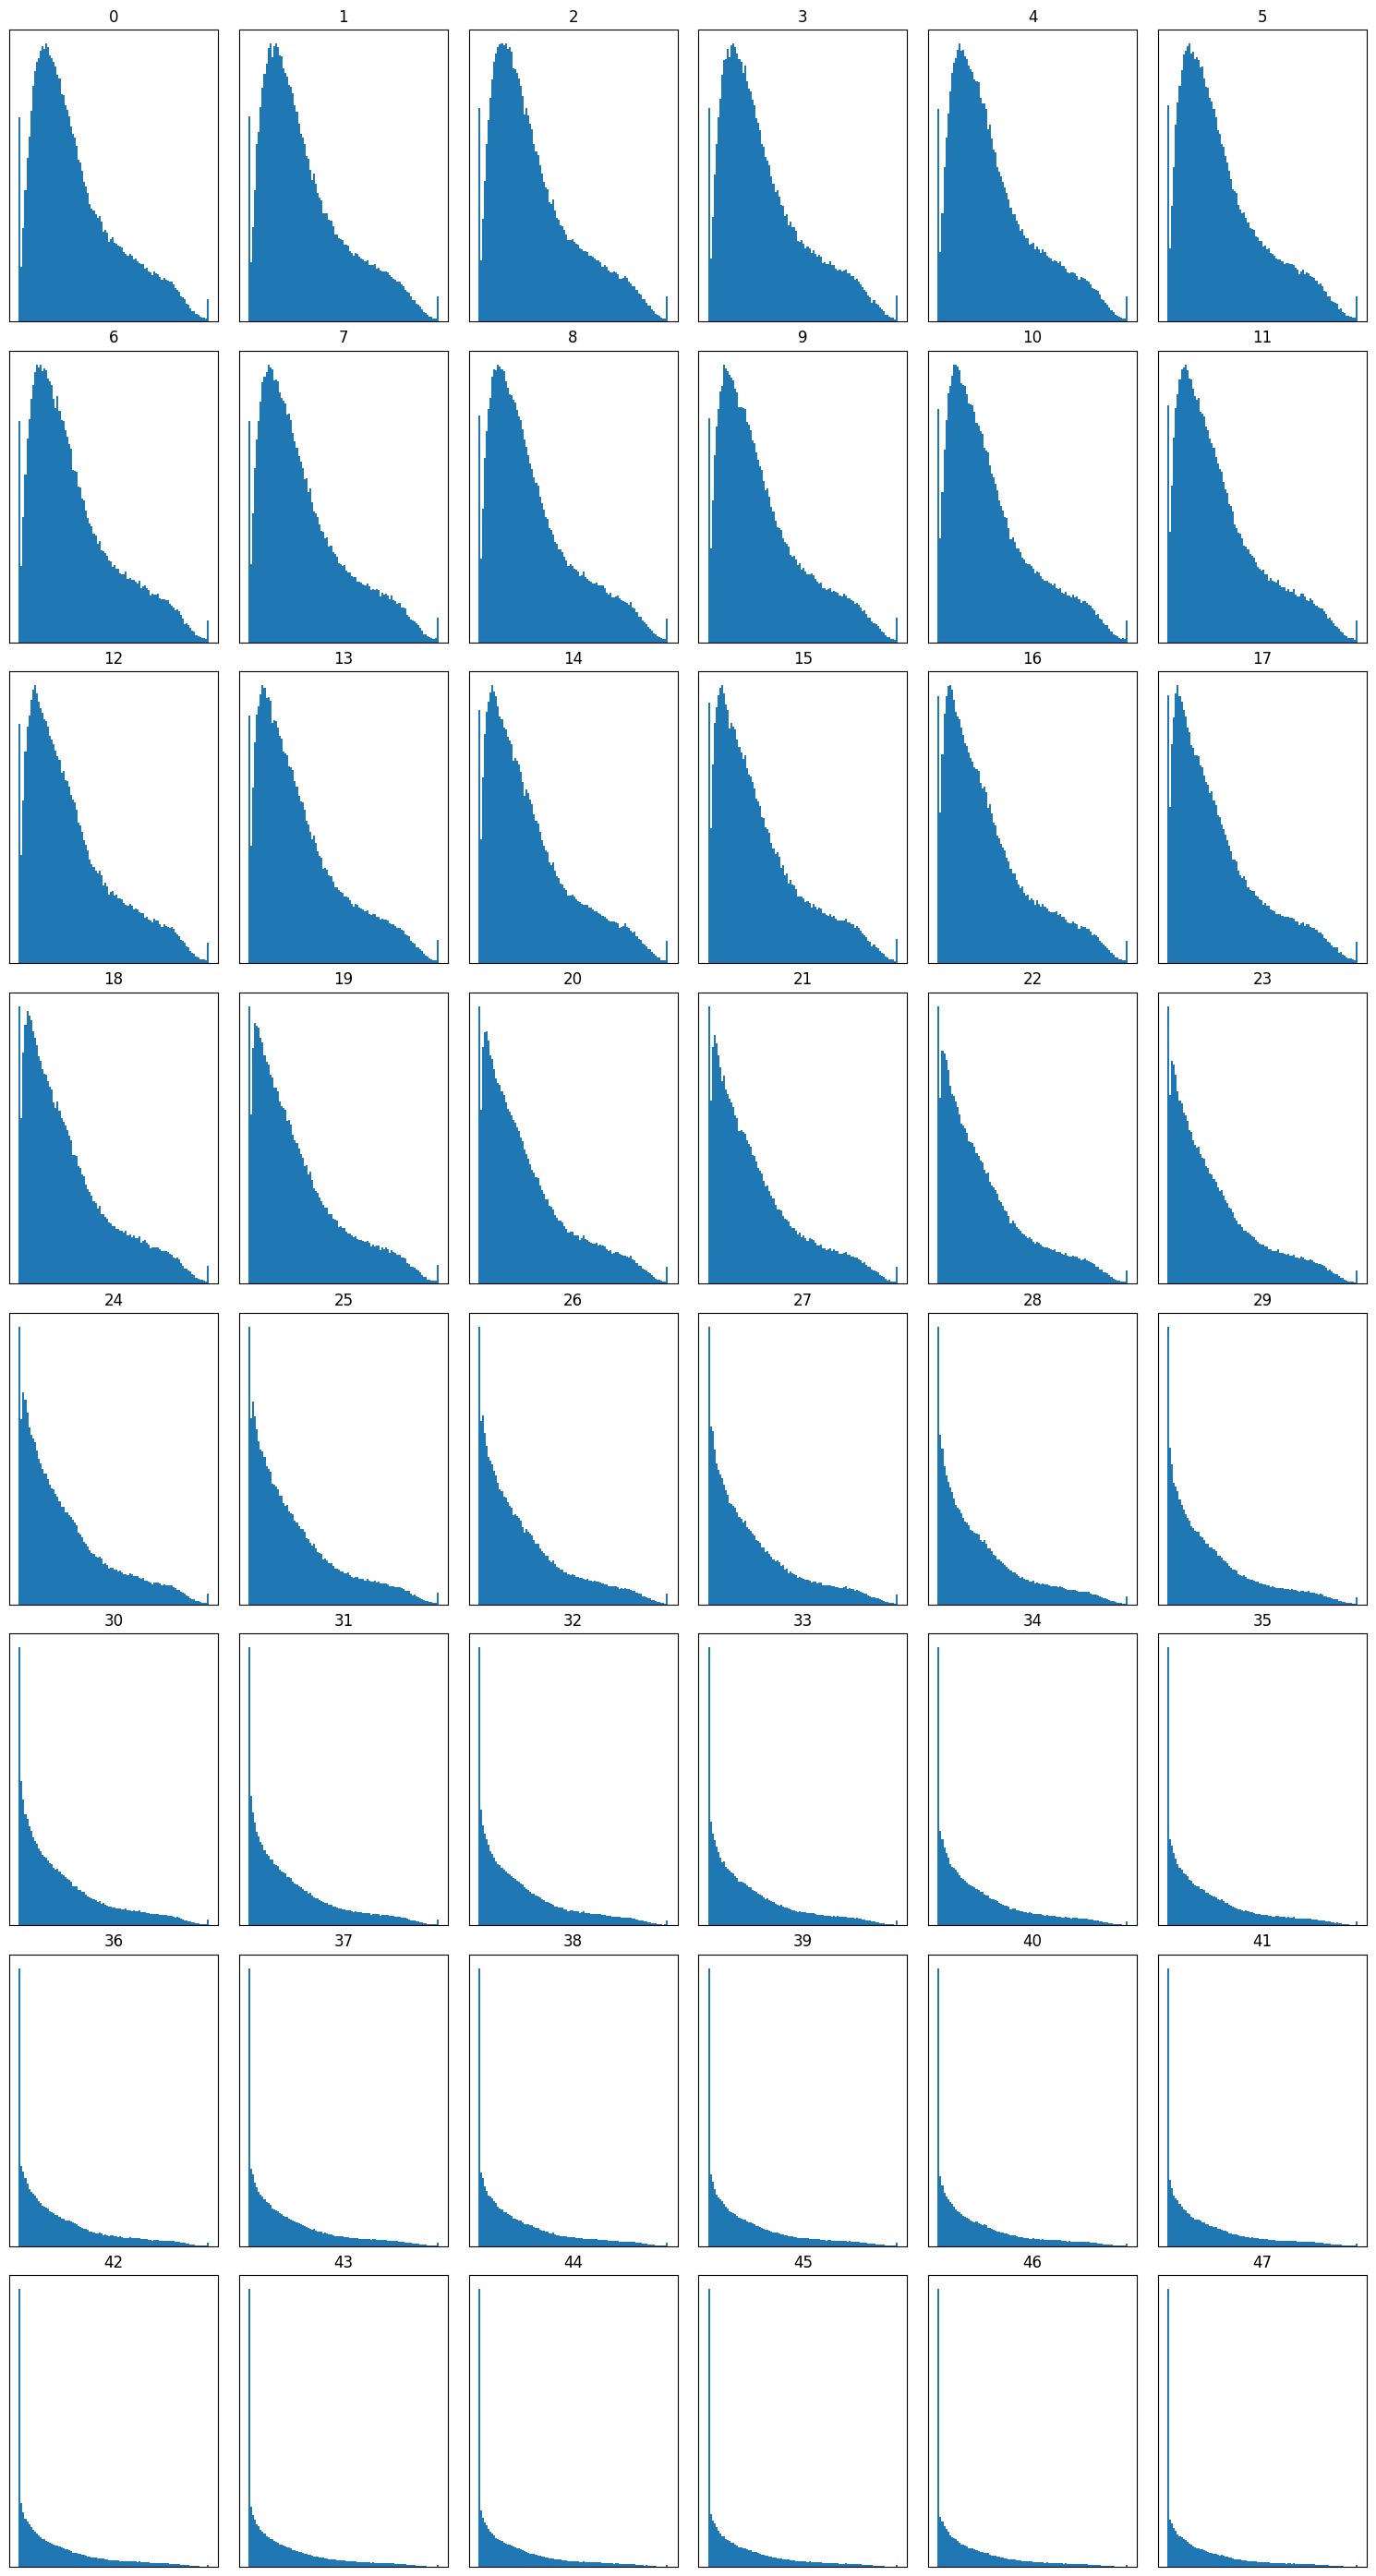

In [82]:
fig, axes = plt.subplots(
    nrows=8,
    ncols=6,
    figsize=(15, 28),
)

for i in range(8):
    for j in range(6):
        axes[i][j].hist(all_y[:,i * 6 + j], bins=np.arange(0,1.01,.01))

        axes[i][j].get_xaxis().set_visible(False)
        axes[i][j].get_yaxis().set_visible(False)
        axes[i][j].set_title(f"{i * 6 + j}")

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)

In [88]:
all_y.mean(axis=0, keepdims=True).repeat(16, 0).shape

(16, 48)

## Next steps

Well done for reaching the end of this Jupyter notebook! By now, you will have loaded and explored the data, trained a basic model, and joined other competition participants on the [competition scoreboard](https://doxaai.com/competition/climatehackai-2023/scoreboard)!

To get started, we used a very simple model architecture, but this model most likely does not have a sufficiently rich representation to properly solve our problem. How might you be able to improve on this? Which model architectures would be best suited to this problem? Would you want to train a model from scratch, as we have done here, or possibly fine-tune a pre-trained computer vision model? Check out the resources on the [competition page](https://doxaai.com/competition/climatehackai-2023) for ideas on where to go from here.

Additionally, we only used historical PV and HRV data, but perhaps you might be able to get more mileage out of the other data sources available to you, such as non-HRV satellite imagery, the DWD weather forecast data or even the aerosol data. If you do decide to incorporate more data, what **data engineering** work would you have to perform so that you can train effectively on a large quantity of data?

**We want to hear about your approaches**! If you develop anything interesting, let us know on the [ClimateHack.AI Community Discord server](https://discord.gg/HTTQ8AFjJp) and start a conversation!